## Coursera - Capstone Project for IBM Data Science Certificate

Segmenting and clustering neighborhoods in Toronto 

- Import the data from Wikipedia
 - Clean the dataset

- Get the coordinates from postal codes from CSV file
 - generate a complete dataset 
 - plot it on a map 


- Analyse the trends in the data and sort the most common venues 
- Make a clustering algorithm using kmeans 
- Plot the results and comment them.





In [273]:
import pandas as pd
import numpy  as np
import folium
import codecs 
import requests
import folium
from bs4 import BeautifulSoup

In [274]:
import json
from geopy.geocoders import Nominatim 
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns


In [275]:
#go and get the data from the wikipedia page 
#1) create the url which will be used. 

wikipage='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#2)  create a html to be parsed 

wiki_html= requests.get(wikipage).text

In [276]:
#3) beutify it 
soup= BeautifulSoup(wiki_html,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":906439794,"wgRevisionId":906439794,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June",

In [277]:
npa_table= soup.find('table')
npa_table= npa_table.find_all('tr')

In [278]:
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [279]:
for row in npa_table:
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n'))


In [280]:
#import the 3 lists in a dataframe
toronto_df= pd.DataFrame({"PostalCode":postalCodeList,
                          "Borough": boroughList,
                          "Neighborhood":neighborhoodList})

In [281]:
print(toronto_df.shape)
toronto_df.head()


(288, 3)


,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [282]:
#Process the dataframe. 
#ignore the cells in which borough is not assigned 

toronto_df_clean=toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
print(toronto_df_clean.shape)
toronto_df_clean.head()

(211, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [283]:

toronto_df_cleaner= toronto_df_clean.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ",".join(x))

toronto_df_cleaner.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [284]:
#grouped_df= toronto_df_clean.groupby(["PostalCode", "Borough"], as_index=False)
#for key, item in grouped_df:
 #   print(grouped_df.get_group(key), "\n\n")

In [285]:
toronto_df_cleaner.Neighborhood.where(toronto_df_cleaner.Neighborhood=='Not assigned').count()

1

In [286]:
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_cleaner.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
toronto_df_cleaner.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [287]:
toronto_df_cleaner.Neighborhood.where(toronto_df_cleaner.Neighborhood=='Not assigned').count()

0

In [288]:
print('The resulting dataset has',toronto_df_cleaner.shape,'fields')

The resulting dataset has (103, 3) fields


In [289]:
#### This is the part where we get coordinates from a csv file 

In [290]:
url='http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv'
coord=pd.read_csv(url)
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [291]:
coord.dtypes

Postal Code     object
Latitude       float64
Longitude      float64
dtype: object

In [292]:
#change column names to be coherent 
column_names= ['PostalCode','Latitude','Longitude']
coord.columns=column_names

In [293]:
print(coord.shape)
coord.head()

(103, 3)


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [294]:
#merging with the existing dataframe

toronto_final=pd.merge(toronto_df_cleaner,coord, on='PostalCode',how='inner')
print('Merge done, we have',toronto_final.shape,'columns')
toronto_final.head()

Merge done, we have (103, 5) columns


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Explore the dataset 

Make a map with all the neighborhoods 

In [295]:
address = 'Toronto'

geolocator = Nominatim(user_agent="week-3")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [296]:
#make a map 

map1= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_final['Latitude'],toronto_final['Longitude'], toronto_final['Borough'], toronto_final['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map1)  
map1

### Select only the neighborhood which contain the word Toronto

In [297]:
toronto_final.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [298]:
toronto_neigh= toronto_final[toronto_final.Borough.str.contains('Toronto',case=False)]
print(toronto_neigh.shape,'the names are',toronto_neigh.Borough.unique())
toronto_neigh.head()

(38, 5) the names are ['East Toronto' 'Central Toronto' 'Downtown Toronto' 'West Toronto']


,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


## Call the Foursquare API to retrieve information on those 38 neighbourhoods 

In [299]:
CLIENT_ID = 'WX1VEFIP5VP3N41R23CXEYWHUKFWR1X5QHX2DT0T0SSGJO4Z' # your Foursquare ID
CLIENT_SECRET = 'UKQY4JTNIOA35QTKYMBFIIRJODZUUARA5LK5O4YP5PE3WWXM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials on the foursquare API ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentials on the foursquare API 
CLIENT_ID: WX1VEFIP5VP3N41R23CXEYWHUKFWR1X5QHX2DT0T0SSGJO4Z
CLIENT_SECRET:UKQY4JTNIOA35QTKYMBFIIRJODZUUARA5LK5O4YP5PE3WWXM


In [300]:
EX=toronto_neigh.iloc[0,:]
EX

PostalCode               M4E
Borough         East Toronto
Neighborhood     The Beaches
Latitude             43.6764
Longitude            -79.293
Name: 37, dtype: object

## Try to call the API once to familiarise with the results 

In [301]:
#Define number of maximum requests and also the radius you will need to make the research 
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    EX.Latitude, 
    EX.Longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=WX1VEFIP5VP3N41R23CXEYWHUKFWR1X5QHX2DT0T0SSGJO4Z&client_secret=UKQY4JTNIOA35QTKYMBFIIRJODZUUARA5LK5O4YP5PE3WWXM&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [302]:
results = requests.get(url).json()#["response"]['groups'][0]['items']
results['response']['groups'][0]['items'][0]['venue']#['location']

{'id': '4bd461bc77b29c74a07d9282',
 'name': 'Glen Manor Ravine',
 'location': {'address': 'Glen Manor',
  'crossStreet': 'Queen St.',
  'lat': 43.67682094413784,
  'lng': -79.29394208780985,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.67682094413784,
    'lng': -79.29394208780985}],
  'distance': 89,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Glen Manor (Queen St.)', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d159941735',
   'name': 'Trail',
   'pluralName': 'Trails',
   'shortName': 'Trail',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/hikingtrail_',
    'suffix': '.png'},
   'primary': True}],
 'photos': {'count': 0, 'groups': []}}

In [303]:
results

{'meta': {'code': 200, 'requestId': '5d629137fd16bb002c09dd3f'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682094413784,
          'lng': -79.29394208780985}],
        'distanc

Use the function from laboratory to get values for nearby venues 

In [304]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [305]:
toronto_neigh.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [306]:
# Use the function to get values of nearby venues in neighborhoods 
toronto_venues = getNearbyVenues(names=toronto_neigh['Neighborhood'],
                                   latitudes=toronto_neigh['Latitude'],
                                   longitudes=toronto_neigh['Longitude']
                                  )


The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvall

In [307]:
temp=toronto_neigh[['PostalCode','Borough','Neighborhood']]
temp.head()

,PostalCode,Borough,Neighborhood
37,M4E,East Toronto,The Beaches
41,M4K,East Toronto,"The Danforth West,Riverdale"
42,M4L,East Toronto,"The Beaches West,India Bazaar"
43,M4M,East Toronto,Studio District
44,M4N,Central Toronto,Lawrence Park


In [308]:
toronto_venues2=pd.merge(toronto_venues,temp,on='Neighborhood',indicator='left_only')
toronto_venues2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,PostalCode,Borough,left_only
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,M4E,East Toronto,both
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,M4E,East Toronto,both
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,M4E,East Toronto,both
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood,M4E,East Toronto,both
4,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop,M4E,East Toronto,both


In [309]:
toronto_venues2.drop(columns='left_only',inplace=True)
toronto_venues2.head()
toronto_venues2.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category',
       'PostalCode', 'Borough'],
      dtype='object')

In [310]:
#checking how many results do we get 
toronto_venues2.shape

(1699, 9)

In [311]:
#chekc how many venues per neighborhoods we get 
print('The number of unique categories is',len(toronto_venues2['Venue Category'].unique()))
toronto_venues2.groupby('Neighborhood').count()

The number of unique categories is 239


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,PostalCode,Borough
Neighborhood,,,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57,57,57
"Brockton,Exhibition Place,Parkdale Village",21,21,21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19,19,19
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",14,14,14,14,14,14,14,14
"Cabbagetown,St. James Town",45,45,45,45,45,45,45,45
Central Bay Street,84,84,84,84,84,84,84,84
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100,100,100
Christie,15,15,15,15,15,15,15,15


In [312]:
#The 20 most present categories are
print(toronto_venues2['Venue Category'].value_counts()[0:20])

Coffee Shop            143
Café                    87
Restaurant              53
Italian Restaurant      47
Bakery                  43
Hotel                   39
Bar                     37
Park                    35
Pizza Place             34
Gym                     25
Japanese Restaurant     25
Gastropub               23
American Restaurant     23
Seafood Restaurant      22
Sandwich Place          22
Breakfast Spot          21
Thai Restaurant         21
Steakhouse              21
Pub                     20
Ice Cream Shop          20
Name: Venue Category, dtype: int64


## Get a better understanding of each neighborhood 

In [313]:
# one hot encoding
toronto_onehot=[]
toronto_onehot = pd.get_dummies(toronto_venues2[['Venue Category']], prefix="", prefix_sep="")

print(toronto_onehot.shape, toronto_onehot.columns)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues2['Neighborhood'] 
toronto_onehot['PostalCode']=toronto_venues2['PostalCode']
toronto_onehot['Borough']=toronto_venues2['Borough']
print(toronto_onehot.shape)
print(toronto_onehot.columns)

(1699, 239) Index(['Afghan Restaurant', 'Airport', 'Airport Food Court', 'Airport Gate',
       'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'American Restaurant', 'Antique Shop', 'Aquarium',
       ...
       'Toy / Game Store', 'Trail', 'Train Station',
       'Vegetarian / Vegan Restaurant', 'Video Game Store', 'Video Store',
       'Vietnamese Restaurant', 'Wine Bar', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=239)
(1699, 241)
Index(['Afghan Restaurant', 'Airport', 'Airport Food Court', 'Airport Gate',
       'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'American Restaurant', 'Antique Shop', 'Aquarium',
       ...
       'Train Station', 'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Video Store', 'Vietnamese Restaurant', 'Wine Bar', 'Women's Store',
       'Yoga Studio', 'PostalCode', 'Borough'],
      dtype='object', length=241)


In [314]:
# move neighborhood column to the first column
filters=['Neighborhood','PostalCode','Borough']
fixed_columns = filters + list(toronto_onehot.columns[~toronto_onehot.columns.isin( filters) ])
toronto_onehot = toronto_onehot[fixed_columns]
print('How many do we get',toronto_onehot.shape)
toronto_onehot.head()

How many do we get (1699, 241)


,Neighborhood,PostalCode,Borough,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,The Beaches,M4E,East Toronto,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,M4E,East Toronto,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,M4E,East Toronto,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,M4E,East Toronto,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,M4E,East Toronto,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Like the exercise let's print the first 10 venues for each neighborhood 

In [315]:
toronto_grouped = toronto_onehot.groupby([ 'PostalCode','Borough','Neighborhood']).mean().reset_index()
print('the shape',toronto_grouped.shape)
toronto_grouped.head()

the shape (38, 241)


,PostalCode,Borough,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.20000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,M4K,East Toronto,"The Danforth West,Riverdale",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810
2,M4L,East Toronto,"The Beaches West,India Bazaar",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,M4M,East Toronto,Studio District,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025641
4,M4N,Central Toronto,Lawrence Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [316]:
num_top_venues = 5

toronto_formapping=toronto_grouped.drop(columns=['PostalCode','Borough'],inplace=False)

for hood in toronto_formapping['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_formapping[toronto_formapping['Neighborhood'] == hood].T.reset_index()
    print(temp.columns)
    
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----The Beaches----
Index(['index', 0], dtype='object')
               venue  freq
0        Coffee Shop   0.2
1  Health Food Store   0.2
2                Pub   0.2
3              Trail   0.2
4  Afghan Restaurant   0.0


----The Danforth West,Riverdale----
Index(['index', 1], dtype='object')
                    venue  freq
0        Greek Restaurant  0.21
1             Coffee Shop  0.10
2      Italian Restaurant  0.07
3          Ice Cream Shop  0.05
4  Furniture / Home Store  0.05


----The Beaches West,India Bazaar----
Index(['index', 2], dtype='object')
          venue  freq
0   Pizza Place  0.11
1  Liquor Store  0.06
2     Pet Store  0.06
3           Pub  0.06
4          Park  0.06


----Studio District----
Index(['index', 3], dtype='object')
                 venue  freq
0                 Café  0.10
1          Coffee Shop  0.08
2   Italian Restaurant  0.05
3  American Restaurant  0.05
4               Bakery  0.05


----Lawrence Park----
Index(['index', 4], dtype='object')
            

              venue  freq
0    Breakfast Spot  0.13
1         Gift Shop  0.13
2        Restaurant  0.07
3  Cuban Restaurant  0.07
4      Dessert Shop  0.07


----Runnymede,Swansea----
Index(['index', 36], dtype='object')
              venue  freq
0              Café  0.08
1       Coffee Shop  0.08
2             Diner  0.06
3  Sushi Restaurant  0.06
4       Pizza Place  0.06


----Business Reply Mail Processing Centre 969 Eastern----
Index(['index', 37], dtype='object')
                venue  freq
0  Light Rail Station  0.11
1         Yoga Studio  0.05
2                Park  0.05
3          Comic Shop  0.05
4    Recording Studio  0.05




In [317]:
#Reuse the function from the exerciese to sort values in a dataframe 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [318]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_formapping['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_formapping.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,Trail,Pub,Health Food Store,Coffee Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio
1,"The Danforth West,Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Burger Joint
2,"The Beaches West,India Bazaar",Pizza Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Liquor Store,Fish & Chips Shop,Fast Food Restaurant,Movie Theater,Park,Pet Store
3,Studio District,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Convenience Store,Brewery,Seafood Restaurant,Sandwich Place
4,Lawrence Park,Park,Bus Line,Dim Sum Restaurant,Swim School,Yoga Studio,Donut Shop,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


# Now we should be able to apply clustering to the neighborhood to prove if they can be matched or not 

In [319]:
 # set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_formapping.drop('Neighborhood' , 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 


array([0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

len of clusters  10
len of inertia  10


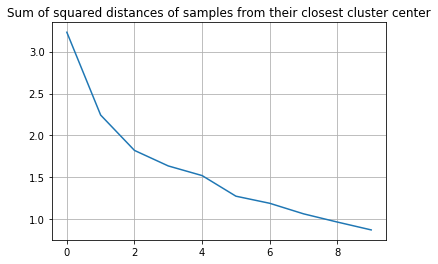

In [320]:
#choose the most efficient number of clusters 

clusters=np.linspace(1,10,10).astype(int)
print('len of clusters ',len(clusters))
inertia=np.zeros(len(clusters))
print('len of inertia ',len(inertia))
for kk in clusters:
    kmeans_test = KMeans(n_clusters=kk, random_state=0).fit(toronto_grouped_clustering)
    inertia[kk-1]=kmeans_test.inertia_
plt.plot(inertia)
plt.title('Sum of squared distances of samples from their closest cluster center')
plt.grid()
    

We might see a slow slope decrease at arount 5. We shall use it, in every other case the potential of clusterisability of the sample is not enormous as one might see in the graph here. 

Text(0.5, 1.0, 'Number of neighborhoods in each cluster')

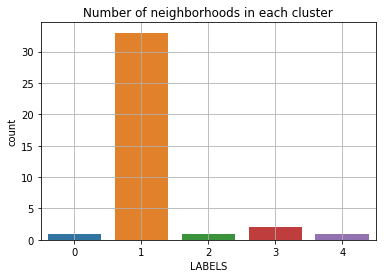

In [331]:
labels=pd.DataFrame({'LABELS':kmeans.labels_})

sns.countplot(x='LABELS',data=labels)
plt.grid()
plt.title('Number of neighborhoods in each cluster')

In [332]:
## Add clustering labels 
try:
    neighborhoods_venues_sorted.insert(0,'ClusterLabels',kmeans.labels_)
except:
    neighborhoods_venues_sorted['ClusterLabels']=kmeans.labels_

In [333]:
toronto_merged=pd.merge(toronto_neigh,neighborhoods_venues_sorted,on='Neighborhood')
print(toronto_merged.shape)
toronto_merged.head()


(38, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Pub,Health Food Store,Coffee Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Burger Joint
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,1,Pizza Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Liquor Store,Fish & Chips Shop,Fast Food Restaurant,Movie Theater,Park,Pet Store
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Convenience Store,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Dim Sum Restaurant,Swim School,Yoga Studio,Donut Shop,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


### Generate a map out of the clusters 

In [334]:
# create map
latitude = 43.654260
longitude = -79.520999

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### See the different cluster and discover why they are different

In [325]:
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Pub,Health Food Store,Coffee Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Burger Joint
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,1,Pizza Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Liquor Store,Fish & Chips Shop,Fast Food Restaurant,Movie Theater,Park,Pet Store
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Convenience Store,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Dim Sum Restaurant,Swim School,Yoga Studio,Donut Shop,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market


In [326]:
    
    toronto_merged.loc[toronto_merged['ClusterLabels'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Pub,Health Food Store,Coffee Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio


In [327]:
    
    toronto_merged.loc[toronto_merged['ClusterLabels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Burger Joint
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,1,Pizza Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Liquor Store,Fish & Chips Shop,Fast Food Restaurant,Movie Theater,Park,Pet Store
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Convenience Store,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Bus Line,Dim Sum Restaurant,Swim School,Yoga Studio,Donut Shop,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Sandwich Place,Clothing Store,Dog Run,Breakfast Spot,Hotel,Gym,Park,Dance Studio,Food & Drink Shop,Dumpling Restaurant
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Coffee Shop,Clothing Store,Sporting Goods Shop,Yoga Studio,Furniture / Home Store,Dessert Shop,Diner,Rental Car Location,Restaurant,Chinese Restaurant
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,Pizza Place,Sandwich Place,Dessert Shop,Italian Restaurant,Café,Restaurant,Coffee Shop,Sushi Restaurant,Thai Restaurant,Pharmacy
9,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,1,Coffee Shop,Pub,American Restaurant,Sushi Restaurant,Restaurant,Bagel Shop,Sports Bar,Supermarket,Liquor Store,Light Rail Station
11,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,1,Park,Coffee Shop,Bakery,Café,Convenience Store,Restaurant,Italian Restaurant,Pizza Place,Pub,Beer Store
12,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Pub,Bubble Tea Shop,Burger Joint,Fast Food Restaurant,Café


In [328]:
    
    toronto_merged.loc[toronto_merged['ClusterLabels'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,M5N,Central Toronto,Roselawn,43.711695,-79.416936,2,Garden,Yoga Studio,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


In [329]:
    
    toronto_merged.loc[toronto_merged['ClusterLabels'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,3,Playground,Gym,Park,Restaurant,Dive Bar,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,3,Park,Playground,Building,Trail,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


In [330]:
    
    toronto_merged.loc[toronto_merged['ClusterLabels'] == 4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,M5P,Central Toronto,"Forest Hill North,Forest Hill West",43.696948,-79.411307,4,Trail,Park,Sushi Restaurant,Jewelry Store,Fast Food Restaurant,Filipino Restaurant,Farmers Market,Falafel Restaurant,Doner Restaurant,Event Space


Observation: 
- Lot of neighborhoods are clustered with the same label and the analysis on the number of clusters might not be showing improvement in increasing the number of clusters 
- the main caracteristic of the 0th cluster is to have a predominance of trail shops and health food stores 
- the main caracteristic of the 1th cluster is to have lots of cafes and restaurant.
- the main caracteristic of the 2nd cluster is to have lots of flower shops and garden shopps
- the main caracteristic of the 3rd cluster is to have lots of parks and playgrounds
- the main caracteristic of the 4th cluster is to have trail and park venues. 

An improvement of the algorithm might be to include other factors as classificators for the neighborhoods such as income or population. 

This file will be uploded to GitHub and shared for peers review. 

Patrizio Canzi 25072019 